In [1]:
import gradio as gr
import json
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
import sys

# Sets Current Directory to Parent Path
sys.path.insert(0, '..')

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from src.utils.dataset import download_dataset, convert_dataset

In [2]:
DATASET_URL = 'https://github.com/yaleemmlc/admissionprediction/raw/master/Results/5v_cleandf.RData'
FILE_PATH = '../data'
FILE_NAME = 'Results.rdata'
PRIORITY_FILE = 'Priority.xlsx'
DEMO_FILE = 'Demo.csv'

# Downloads the Original Dataset (RData File)
DATASET_RDATA_PATH = download_dataset(DATASET_URL, FILE_PATH, FILE_NAME)

# Sets the Path for Priority File
PRIORITY_FILE_PATH = DATASET_RDATA_PATH.replace(FILE_NAME, PRIORITY_FILE)

# Sets the Path for Demo Data File
DEMO_FILE_PATH = PRIORITY_FILE_PATH.replace(PRIORITY_FILE, DEMO_FILE)

# Converts the RData File to a New CSV File
DATASET_CSV_PATH = convert_dataset(DATASET_RDATA_PATH, DATASET_RDATA_PATH.replace('.rdata', '.csv'))

In [10]:
# dataset = pl.read_csv(DATASET_CSV_PATH).to_pandas()
dataset = pd.read_csv(DATASET_CSV_PATH)

dataset.head()

,Unnamed: 0,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,0,B,4.0,40.0,Male,Hispanic or Latino,White or Caucasian,English,NaN,Single,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,B,4.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,B,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,A,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,A,3.0,84.0,Female,Hispanic or Latino,Other,Other,Pentecostal,Widowed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
dataset.describe()

,,esi,age,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
count,560486.000000,558029.000000,560475.000000,560486.000000,560486.000000,560486.000000,560486.000000,560486.000000,560486.000000,560486.000000,...,557901.000000,557901.000000,557901.000000,557901.000000,557901.000000,557901.000000,557901.000000,557901.000000,557901.000000,557901.000000
mean,280242.500000,3.012385,49.876765,0.002155,0.030634,0.014807,0.000023,0.005179,0.009968,0.051054,...,0.001298,0.000717,0.013085,0.001052,0.001165,0.004219,0.002863,0.001233,0.001393,0.002518
std,161798.515826,0.869106,20.417029,0.046375,0.172324,0.120779,0.004816,0.071782,0.099342,0.220108,...,0.036001,0.026900,0.113638,0.032475,0.034113,0.064820,0.053426,0.035095,0.037293,0.050156
min,0.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,140121.250000,2.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,280242.500000,3.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,420363.750000,4.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,560485.000000,5.000000,108.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [11]:
# priorization = pl.read_excel(PRIORITY_FILE_PATH).to_pandas()
priorization = pd.read_excel(PRIORITY_FILE_PATH)

priorization.head()

,Type,Name,Label,Gender,Priority
0,Mental,cc_addictionproblem,addiction problem,both,6
1,Mental,cc_agitation,agitation,both,4
2,Mental,cc_alcoholproblem,alcohol problem,both,6
3,Mental,cc_anxiety,anxiety,both,5
4,Mental,cc_depression,depression,both,5


In [6]:
priorization.describe()

,Priority
count,143.000000
mean,5.979021
std,1.607502
min,1.000000
25%,5.000000
50%,6.000000
75%,7.000000
max,10.000000


In [12]:
# demoData = pl.read_csv(DEMO_FILE_PATH).to_pandas()
demoData = pd.read_csv(DEMO_FILE_PATH)

demoData.head()

,cc_addictionproblem,cc_agitation,cc_alcoholproblem,cc_anxiety,cc_depression,cc_detoxevaluation,cc_hallucinations,cc_homicidal,cc_panicattack,cc_psychoticsymptoms,...,cc_abdominalpainpregnant,cc_constipation,cc_diarrhea,cc_epigastricpain,cc_hematuria,cc_hemoptysis,cc_nausea,cc_flankpain,cc_rectalbleeding,cc_rectalpain
0,False,False,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
demoData.describe()

,cc_addictionproblem,cc_agitation,cc_alcoholproblem,cc_anxiety,cc_depression,cc_detoxevaluation,cc_hallucinations,cc_homicidal,cc_panicattack,cc_psychoticsymptoms,...,cc_abdominalpainpregnant,cc_constipation,cc_diarrhea,cc_epigastricpain,cc_hematuria,cc_hemoptysis,cc_nausea,cc_flankpain,cc_rectalbleeding,cc_rectalpain
count,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
unique,1,1,1,1,2,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,5,5,5,5,4,5,4,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [13]:
# Filter Non Used Columns from Dataset based on Priority
columns = priorization['Name'].tolist()
datasetFiltered = dataset[columns]

In [14]:
datasetFiltered.head()

,cc_addictionproblem,cc_agitation,cc_alcoholproblem,cc_anxiety,cc_depression,cc_detoxevaluation,cc_hallucinations,cc_homicidal,cc_panicattack,cc_psychoticsymptoms,...,cc_abdominalpainpregnant,cc_constipation,cc_diarrhea,cc_epigastricpain,cc_hematuria,cc_hemoptysis,cc_nausea,cc_flankpain,cc_rectalbleeding,cc_rectalpain
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Replace all Numbers in the Columns with Boolean Value (True or False)
datasetBoolean = datasetFiltered[columns] != 0

In [16]:
# Delete all Rows That Have Only False
datasetBoolean = datasetBoolean.loc[(datasetBoolean != False).any(axis=1)]

In [17]:
# Creates a Copy of Boolean Dataset
datasetTemp = datasetBoolean.copy()

# Go Column by Column Over Dataset and Replaces Boolean Values with Priority Values
for column in datasetTemp.columns:
    if column in priorization['Name'].values:
        priority_value = priorization.loc[priorization['Name'] == column, 'Priority'].iloc[0]
        # Replace values in df2 with priority values if not equal to 0
        datasetTemp[column] = datasetTemp[column].apply(lambda x: priority_value if x != False else 0)

# Creates a New Column With the Sum of Columns Present in Priorization['Name']
datasetTemp['result'] = datasetTemp[priorization['Name']].sum(axis=1)

finalDataset = pd.concat([datasetBoolean, datasetTemp['result']], axis=1)

C:\Users\verge\AppData\Local\Temp\ipykernel_15244\2869715749.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  datasetTemp['result'] = datasetTemp[priorization['Name']].sum(axis=1)


In [18]:
finalDataset.head()

,cc_addictionproblem,cc_agitation,cc_alcoholproblem,cc_anxiety,cc_depression,cc_detoxevaluation,cc_hallucinations,cc_homicidal,cc_panicattack,cc_psychoticsymptoms,...,cc_constipation,cc_diarrhea,cc_epigastricpain,cc_hematuria,cc_hemoptysis,cc_nausea,cc_flankpain,cc_rectalbleeding,cc_rectalpain,result
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,6
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,7
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,7
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,6
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,9


In [19]:
# Calculates the First Quartile (Q1) and Third Quartile (Q3)
lowerQ = finalDataset['result'].quantile(0.15)
upperQ = finalDataset['result'].quantile(0.85)

# Calculate the Interquartile Range (IQR)
IQR = upperQ - lowerQ

# Define the Lower and Upper Bounds
lower_bound = lowerQ - 1.5 * IQR
upper_bound = upperQ + 1.5 * IQR

# Prune Data Based on Lower and Upper Bounds
prunedDataset = finalDataset[(finalDataset['result'] >= lower_bound) & (finalDataset['result'] <= upper_bound)]

In [20]:
# Data Split Parameters
random_state = 0 
test_size = 0.2
train_size = 0.8

# Creates the X and Y Data from Dataset
X = prunedDataset.drop(columns=['result'])
y = prunedDataset['result']

# Splits Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

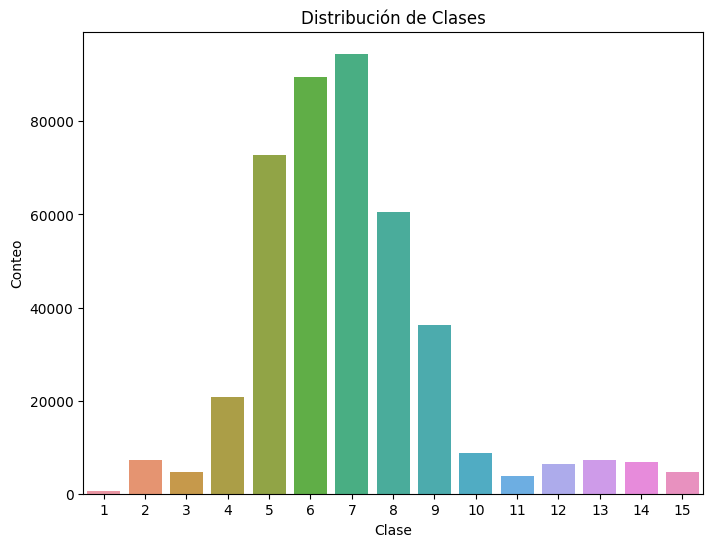

In [21]:
# Encode Categoric Variables
# df_encoded = pd.get_dummies(df_witout_nunique)

# Handling Null values
# imputer = SimpleImputer(strategy='most_frequent')
# df_without_null = imputer.fit_transform(df_witout_nunique)

# Create DataFrame With Encoded Labels and Characteristics
df_plot = X.copy()
df_plot['emergency_flag'] = y

# Plot Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='emergency_flag', data=df_plot)
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Conteo')
plt.show()

In [22]:
# Define Model Parameters
estimators = 100

# Train the Model
model = RandomForestClassifier(n_estimators=estimators, random_state=random_state)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [23]:
# Validate the Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [24]:
# Get Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
TP = confusion[1, 1]

In [25]:
# Calculates Model Metrics from Confusion Matrix

# Precision: Precision measures the accuracy of the positive predictions. It is the ratio of correctly predicted positive observations to the total predicted positives. Precision = TP / (TP + FP).
precision = TP / (TP + FP)

# Recall (Sensitivity): Recall measures the proportion of actual positive cases that were correctly identified by the model. It is the ratio of correctly predicted positive observations to the all observations in actual class. Recall = TP / (TP + FN).
recall = TP / (TP + FN)

# Specificity: Specificity measures the proportion of actual negative cases that were correctly identified by the model. Specificity = TN / (TN + FP).
specificity = TN / (TN + FP)

# False Positive Rate (FPR): FPR measures the proportion of actual negative cases that were incorrectly classified as positive. FPR = FP / (FP + TN).
FPR = FP / (FP + TN)

# F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall. F1 Score = 2 * (Precision * Recall) / (Precision + Recall).
F1 = 2 * (precision * recall) / (precision + recall)

In [26]:
# Prints Model Metrics
metrics = f'Accuracy: {accuracy}, True Positive: {TP}, False Positive: {FP}, True Negative: {TN}, False Negative: {FN}, Precision: {precision}, Recall: {recall}, Specificity: {specificity}, False Positive Rate: {FPR}. F1 Score: {F1}'
print(metrics)

Accuracy: 0.9957090146058541, True Positive: 1411, False Positive: 0, True Negative: 86, False Negative: 0, Precision: 1.0, Recall: 1.0, Specificity: 1.0, False Positive Rate: 0.0. F1 Score: 1.0


In [28]:
# Iterates over Demo Dataframe to 
for index, row in demoData.iterrows():
    # Extract column names where value is True
    true_columns = demoData.columns[row].tolist()
    # Print the result
    print(f"{index}: {', '.join(true_columns)}")

0: cc_depression, cc_hallucinations, cc_abscess, cc_alcoholintoxication
1: cc_lethargy, cc_lossofconsciousness, cc_ribinjury
2: cc_drugproblem, cc_fall, cc_fatigue, cc_headinjury
3: cc_bodyfluidexposure, cc_burn, cc_cellulitis, cc_skinproblem, cc_woundcheck, cc_woundinfection
4: cc_urinaryretention, cc_urinarytractinfection, cc_earpain, cc_earproblem, cc_eyeproblem


In [29]:
# Make Predictions on Demo Data
result = model.predict(demoData)

In [30]:
# Add the Result to the Demo Data
demoData['result'] = result

In [31]:
# Sort the Patients for Priority 
ordered_df = demoData.sort_values(by='result', ascending=False)

# Remove Results Column to Have a Dataframe With Only Booleans Values
ordered_df = ordered_df.drop(columns=['result'])

# Shows the Demo Data Ordered
for index, row in ordered_df.iterrows():
    # Extract column names where value is True
    true_columns = ordered_df.columns[row].tolist()
    # Print the result
    print(f"{index}: {', '.join(true_columns)}")

0: cc_depression, cc_hallucinations, cc_abscess, cc_alcoholintoxication
2: cc_drugproblem, cc_fall, cc_fatigue, cc_headinjury
3: cc_bodyfluidexposure, cc_burn, cc_cellulitis, cc_skinproblem, cc_woundcheck, cc_woundinfection
4: cc_urinaryretention, cc_urinarytractinfection, cc_earpain, cc_earproblem, cc_eyeproblem
1: cc_lethargy, cc_lossofconsciousness, cc_ribinjury
